In [1]:
import csv
from datetime import datetime

import pandas as pd
import seaborn
import matplotlib.pyplot as plt

from ete3 import NCBITaxa
from ebi_eva_internal_pyutils.metadata_utils import get_metadata_connection_handle
from ebi_eva_internal_pyutils.pg_utils import get_all_results_for_query
from fontTools.merge.util import first

ete_db = NCBITaxa()

seaborn.set_style('white')


# File containing password not committed to the repository
private_config_xml_file = 'maven_settings.xml'
query = '''SELECT project_accession  FROM evapro.project WHERE ena_status=4 AND eva_status=1;'''
with get_metadata_connection_handle('production_processing', private_config_xml_file) as db_conn:
    all_project_accessions = [p for p, in get_all_results_for_query(db_conn, query)]
all_project_accessions.remove('PRJEBZ0001')
all_project_accessions.remove('PRJX00001')

/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Generating the TSV file involved querying the accessioning warehouse for dbsnp study name and taxonomy and
# listing the unmapped studies in the filesystem.
with open('dated_studies.tsv') as open_input:
    reader = csv.DictReader(open_input, delimiter='\t')
    required_ranks = ['superkingdom', 'kingdom', 'class', 'order', 'species']
    all_records = []
    all_project_loaded = set()
    for rec in reader:
        lineage = ete_db.get_lineage(int(rec.get('taxid')))
        # Get the rank of each taxonomy ids
        ranks = ete_db.get_rank(lineage)
        # Get the taxonomy of the required ranks
        for required_rank in required_ranks:
            taxid_for_rank = [i for i in ranks if ranks[i] == required_rank]
            if taxid_for_rank:
                # Get the scientific names of the rank
                sci_name_of_required_rank = ete_db.get_taxid_translator(taxid_for_rank)[taxid_for_rank[0]]
            rec[required_rank] = sci_name_of_required_rank
        all_records.append(rec)
        if rec['study_type'] == 'EVA study':
            all_project_loaded.add(rec['project'])

    missing_projects = set(all_project_accessions).difference(all_project_loaded)
    if missing_projects:
        missing_projects_str = ', '.join([f"'{p}'" for p in missing_projects])
        print('Retrieve the missing project dates and taxid from ERAPRO using the following query:')
        print(f"SELECT PROJECT_ID, TAX_ID, substr(TO_CHAR(FIRST_CREATED, 'YYYY-MM'), 0, 7) AS D "
              f"FROM era.project "
              f"WHERE PROJECT_ID IN ({missing_projects_str});")
    extra_projects = all_project_loaded.difference(set(all_project_accessions))
    if extra_projects:
        print(f'{len(extra_projects)} projects have been loaded but are not in the EVA database:')
        print(extra_projects)


/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 30523 was translated into 30522
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


Retrieve the missing project dates and taxid from ERAPRO using the following query:
SELECT PROJECT_ID, TAX_ID, substr(TO_CHAR(FIRST_CREATED, 'YYYY-MM'), 0, 7) AS D FROM era.project WHERE PROJECT_ID IN ('PRJEB74565', 'PRJEB75654', 'PRJEB75934', 'PRJEB60875', 'PRJEB75966', 'PRJEB75736', 'PRJEB75981', 'PRJEB74477', 'PRJEB69292');


In [3]:
df = pd.DataFrame.from_dict(all_records)
df['date'] = pd.to_datetime(df['date'], format="%Y-%m")
# Change the non Eukaryota to use the superkingdom value instead to limit variability
df.loc[df.superkingdom != 'Eukaryota', 'class'] = 'Non-Eukaryota'
# Filter out anything that is not Eukaryota
# df = df[df.superkingdom == 'Eukaryota']
# Change all the class not in the list bellow to others
accepted_classes = {'Aves': 'Birds','Insecta':'Insects','Actinopteri': 'Fish','Mammalia': 'Mammals','Magnoliopsida': 'Flowering plants', 'Non-Eukaryota': 'Non-Eukaryotes'}
# Check ~ which somehow means "NOT IN" in pandas
df.loc[~df['class'].isin(accepted_classes), 'class'] = 'Other eukaryotes'
df = df.replace({'class': accepted_classes})

In [4]:
def aggregate_first_seen(df):
    # Group by taxid to find the most ancient occurrence and drop all the other rows
    # Then group by class and date to count the number of new taxid discovered each month
    # unstack and restack to fill in every combination class/date with 0 if it did not exist
    first_seen_taxid = df.groupby('taxid').apply(lambda g: g.nsmallest(1, "date")).reset_index(drop=True)\
                         .groupby(['class', 'date'])[["taxid"]].count().unstack(fill_value=0).stack().reset_index()
    # Then calculate the cumulative number of species for each class
    first_seen_taxid['Number of species'] = first_seen_taxid.groupby(['class'])['taxid'].cumsum()
    return first_seen_taxid.reset_index()

def aggregate_count_studies(df):
    # Group by class and date to count the number of studies added each month
    # unstack and restack to fill in every combination class/date with 0 if it did not exist
    count_studies = df.groupby(['class', 'date'])[["taxid"]].count().unstack(fill_value=0).stack().reset_index()
    # Then calculate the cumulative number of studies for each class
    count_studies['Number of studies'] = count_studies.groupby(['class'])['taxid'].cumsum()
    return count_studies.reset_index()

def plot_taxid_and_studies(first_seen_taxid, count_studies):
    fig, ax = plt.subplot_mosaic([['left', 'right']], layout='constrained')
    g1 = seaborn.lineplot(data=first_seen_taxid, x='date', y='Number of species', hue='class', ax=ax['left'])
    g1.tick_params(axis='x', rotation=45)
    g1.get_legend().remove()
    g1.grid(False)
    g2 = seaborn.lineplot(data=count_studies, x='date', y='Number of studies', hue='class', ax=ax['right'])
    g2.tick_params(axis='x', rotation=45)
    g2.get_legend().remove()
    g2.grid(False)
    handles, labels = g2.get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels, loc='outside left center', ncol=1, bbox_to_anchor=(1, 0.5))

def plot_taxid(first_seen_taxid):
    g1 = seaborn.lineplot(data=first_seen_taxid, x='date', y='Number of species', hue='class')
    g1.tick_params(axis='x', rotation=45)
    g1.grid(False)


## Show the number of species and studies added to EVA over time

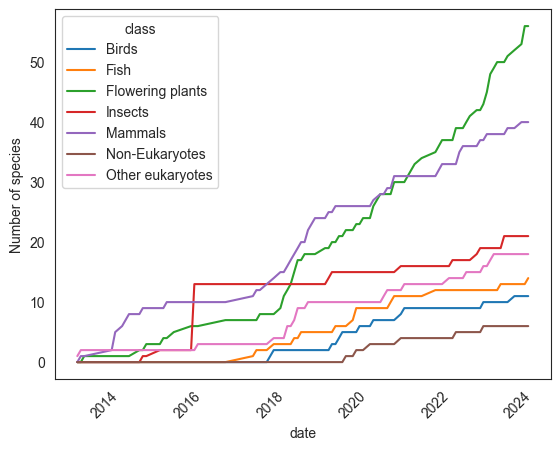

In [5]:
first_seen_taxid = aggregate_first_seen(df)
count_studies = aggregate_count_studies(df)
plot_taxid(first_seen_taxid)

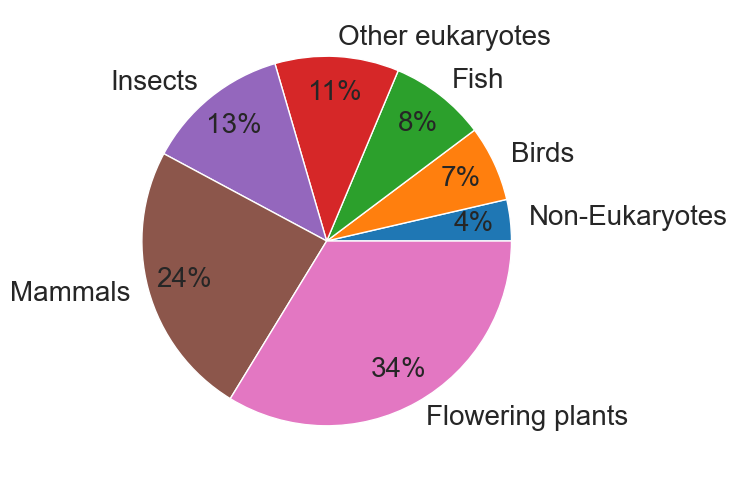

In [73]:
data=df.groupby(['taxid', 'class']).count().reset_index().groupby(['class'])[['taxid']].count().sort_values(by='taxid').reset_index()
data
seaborn.set_style("whitegrid") # Set style for chart
plt.figure(figsize=(6,6)) # Set figure size
plt.pie(data['taxid'], labels=data['class'], autopct='%1.0f%%',  pctdistance=.8, textprops={'fontsize': 20}) # Create pie chart
plt.show() # Show chart

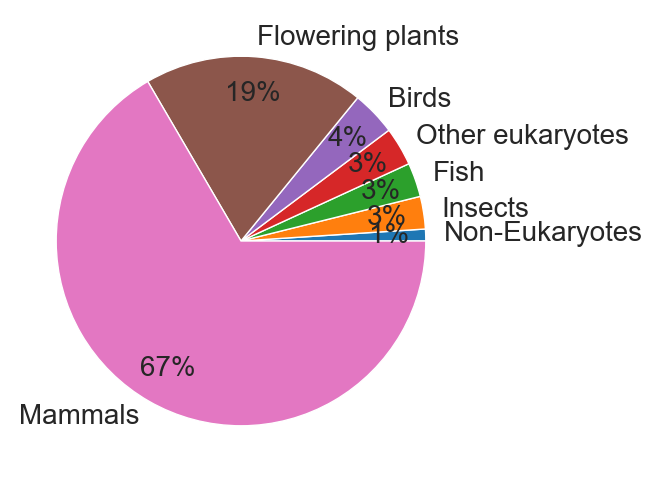

In [71]:
data = df.groupby(['class'])[['project']].count().sort_values(by='project').reset_index()
data
seaborn.set_style("whitegrid") # Set style for chart
plt.figure(figsize=(6,6)) # Set figure size
plt.pie(data['project'], labels=data['class'], autopct='%1.0f%%',  pctdistance=.8, textprops={'fontsize': 20}) # Create pie chart
# plt.pie(sizes, labels=sizes.index, autopct='%1.0f%%',  pctdistance=.8, textprops={'fontsize': 20}) # Create pie chart
plt.show() # Show chart

In [15]:
new_species_in_2020 = sum(first_seen_taxid[(first_seen_taxid['date'] > datetime(year=2020, month=1, day=1)) & (first_seen_taxid['date'] < datetime(year=2021, month=1, day=1))]['taxid'])
new_species_in_2021 = sum(first_seen_taxid[(first_seen_taxid['date'] > datetime(year=2021, month=1, day=1)) & (first_seen_taxid['date'] < datetime(year=2022, month=1, day=1))]['taxid'])
new_species_in_2022 = sum(first_seen_taxid[(first_seen_taxid['date'] > datetime(year=2022, month=1, day=1)) & (first_seen_taxid['date'] < datetime(year=2023, month=1, day=1))]['taxid'])
new_species_in_2023 = sum(first_seen_taxid[(first_seen_taxid['date'] > datetime(year=2023, month=1, day=1)) & (first_seen_taxid['date'] < datetime(year=2024, month=1, day=1))]['taxid'])

print(f"In 2020: {new_species_in_2020} New species were added.")
print(f"In 2021: {new_species_in_2021} New species were added.")
print(f"In 2022: {new_species_in_2022} New species were added.")
print(f"In 2023: {new_species_in_2023} New species were added.")


In 2020: 18 New species were added.
In 2021: 9 New species were added.
In 2022: 15 New species were added.
In 2023: 23 New species were added.


## Show the number of species and studies added to EVA over time (main Eukaryotes)

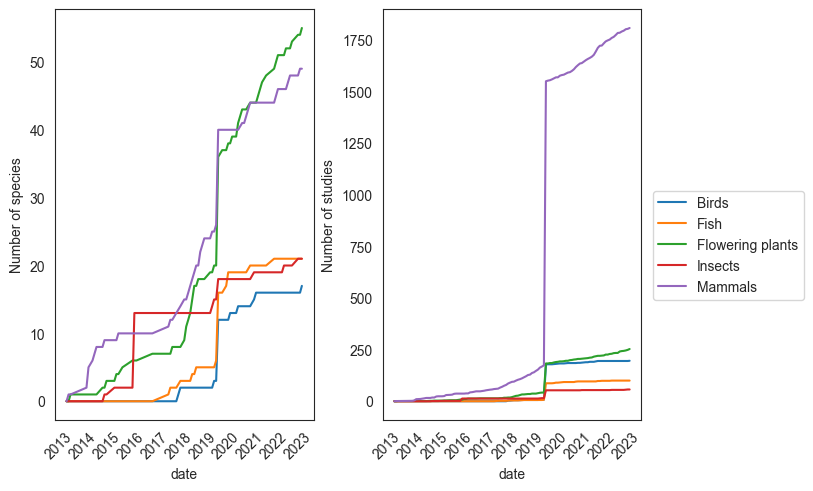

In [6]:
accepted_classes = ['Birds', 'Insects', 'Fish', 'Mammals', 'Flowering plants']
plot_taxid_and_studies(first_seen_taxid[first_seen_taxid['class'].isin(accepted_classes)], count_studies[count_studies['class'].isin(accepted_classes)])

## Show the number of species and studies added to EVA over time (excluding DBSNP studies)

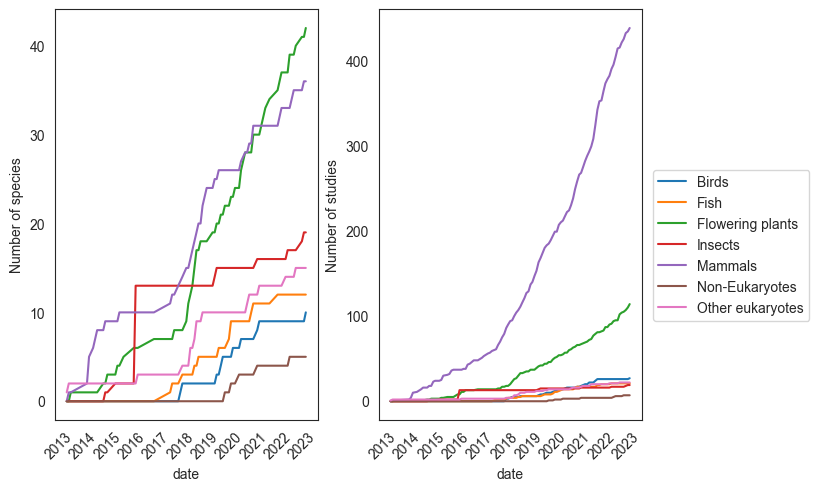

In [7]:
first_seen_taxid = aggregate_first_seen(df[df['study_type'] == 'EVA study'])
count_studies = aggregate_count_studies(df[df['study_type'] == 'EVA study'])
plot_taxid_and_studies(first_seen_taxid, count_studies)

## Show the number of species and studies added to EVA over time (excluding DBSNP studies and main Eukaryotes only)

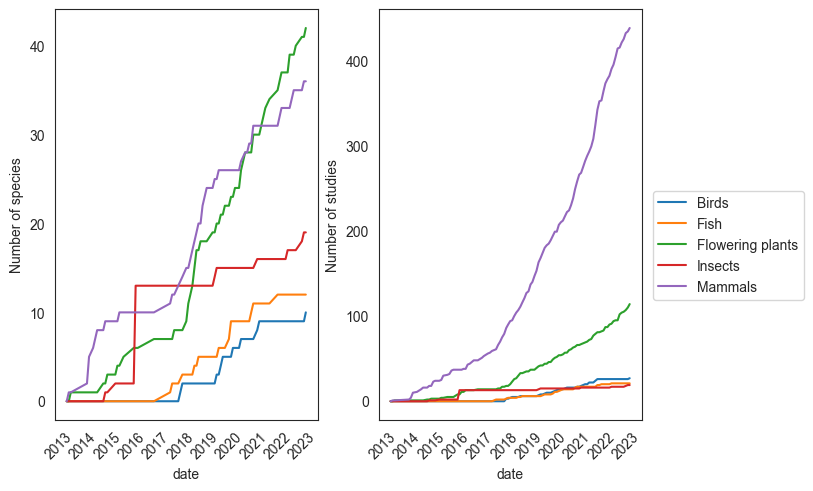

In [8]:
plot_taxid_and_studies(first_seen_taxid[first_seen_taxid['class'].isin(accepted_classes)], count_studies[count_studies['class'].isin(accepted_classes)])

In [12]:
studies_per_month = df.groupby(['date'])[["taxid"]].count().reset_index()
studies_per_month

,date,taxid
0,2013-05-01,1
1,2013-06-01,2
2,2013-07-01,1
3,2014-02-01,1
4,2014-03-01,2
...,...,...
112,2023-12-01,5
113,2024-01-01,3
114,2024-02-01,7
115,2024-03-01,5
